In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DRIVE_PATH = "/content/drive/MyDrive/MTechCSE_2020/Term_Paper/Sem_6_analysis/YoloV8_SAM"

In [4]:
# Root directory of the project
CURR_DIR = "/content/YoloV8_SAM"

In [5]:
!rm -rf CURR_DIR

In [6]:
#ignore all Warnings
import warnings; warnings.simplefilter('ignore')

In [7]:
import shutil
import os
import sys
def loadToMemory():
  if not os.path.exists(CURR_DIR):
    shutil.copytree(DRIVE_PATH, CURR_DIR)
  else:
      print(f"YoloV8_SAM Folder exsist")

In [8]:
loadToMemory()

In [9]:
import os
os.chdir('./YoloV8_SAM')
os.getcwd()

'/content/YoloV8_SAM'

In [10]:
!ls

BrainTumor_YoloV8_SAM.ipynb  dataset  data.yaml  runs


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [11]:
!pip install ultralytics
!pip install supervision
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 8.3 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-swz769_w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-swz769_w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=b9fa9383ba043308dae72b06a3798f7751a61990b7ea4841531629950b4006fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-e7_ba68z/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-07-18 18:23:10--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbai

In [12]:
import numpy as np
import cv2
import os
import sys
import torch

import ultralytics
from IPython.display import display, Image
import matplotlib.pyplot as plt
sys.path.append("..")
ultralytics.checks()

Ultralytics YOLOv8.0.137 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/78.2 GB disk)


In [13]:
DATASET_TRAIN_DIR = "./dataset/train"

!ls $DATASET_TRAIN_DIR

images	labels


In [14]:
import os
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8x.pt')
model.train(data='./data.yaml', epochs=100, batch=64, patience=5, imgsz=640)
# epochs=30 patience=2 imgsz=640 optimizer='SGD'

In [25]:
!scp -r "./runs" "/content/drive/MyDrive/MTechCSE_2020/Term_Paper/Sem_6_analysis/YoloV8_SAM"

In [ ]:
from ultralytics.engine.model import TASK_MAP
import cv2

model_path = './runs/detect/train4/weights/best.pt'

model = YOLO(model_path)

metrics = model.val(data='./data.yaml')

In [15]:
from ultralytics.engine.model import TASK_MAP
import cv2

model_path = './runs/detect/train4/weights/best.pt'
image_path = './dataset/test/images/y798_jpg.rf.d4b67082a13b8a398d76196acc280b66.jpg'
model = YOLO(model_path)

# results = model(img)
results = model.predict(image_path, conf=0.25)


image 1/1 /content/YoloV8_SAM/dataset/test/images/y798_jpg.rf.d4b67082a13b8a398d76196acc280b66.jpg: 640x640 1 Tumor, 8.2ms
Speed: 7.0ms preprocess, 8.2ms inference, 31.7ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
results

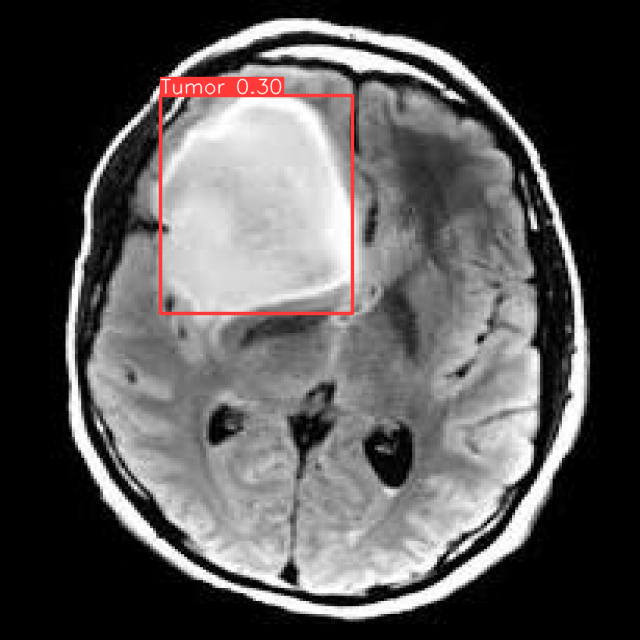

In [17]:
from PIL import Image
Image.fromarray(results[0].plot()[:,:,::-1])

In [ ]:
!yolo predict model='./runs/detect/train4/weights/best.pt' conf=0.25 source='./dataset/test/images'

In [19]:
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs

bbox=boxes.xyxy.tolist()[0]

In [20]:
bbox

[160.99339294433594, 95.50861358642578, 352.666259765625, 313.27435302734375]

In [21]:
image = cv2.cvtColor(cv2.imread('./dataset/test/images/y798_jpg.rf.d4b67082a13b8a398d76196acc280b66.jpg'), cv2.COLOR_BGR2RGB)

In [22]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [23]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [24]:
input_box = np.array(bbox)

In [26]:
boxes = result.boxes.xyxy
print('Shape of boxes array:', boxes.shape)
print('Size of boxes array:', boxes.size)
print(boxes)

Shape of boxes array: torch.Size([1, 4])
Size of boxes array: <built-in method size of Tensor object at 0x7e4e2cc37dd0>
tensor([[160.9934,  95.5086, 352.6663, 313.2744]], device='cuda:0')


## Convert Bounding Box to Segmentation Mask

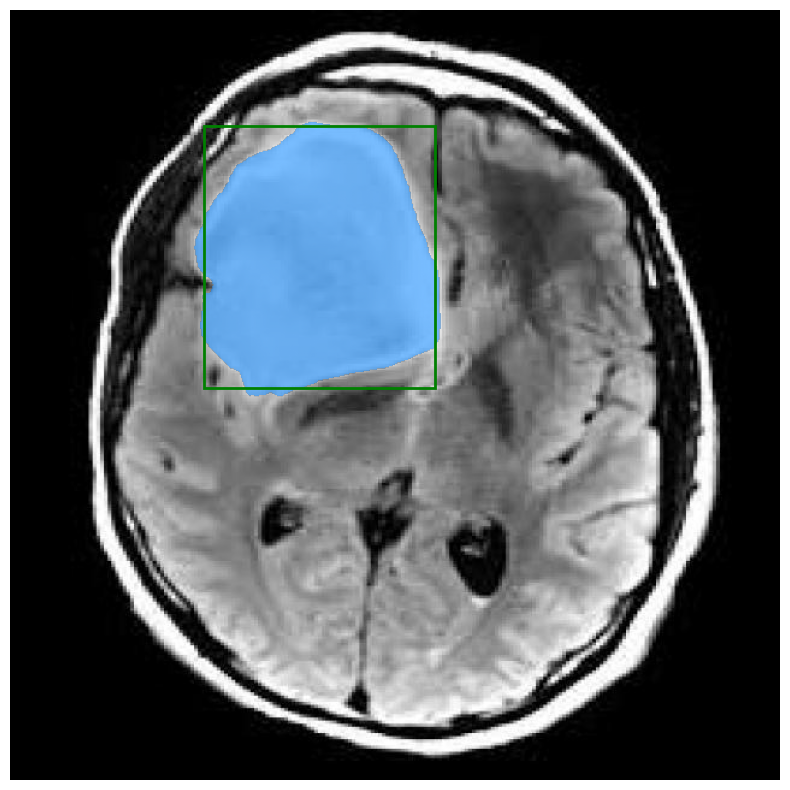

In [22]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

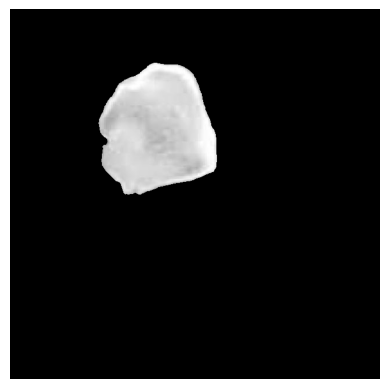

In [24]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 000

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()